## Visualize the outputs of the trained model

In [1]:
# Import statements

from operator import add

from tqdm import tqdm
from dataset import get_data

from models import *
from metrics import *
from utils import read_image, process_image
import random
import cv2
import numpy as np
import torch
from models import *
from glob import glob
import matplotlib.pyplot as plt
from dataset import *

/Users/jeremiahfadugba/opt/anaconda3/envs/retina/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Preambles

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
configs = {"model": "Unet",
           "data": "fives",
           "loss_fn": "clDice",
           "size": (224, 224),
           "augments": False,
           "data_path": 'datasets/',
           "result_path": 'results',
           "device": "cuda",
           "learning_rate": 0.001,
           "batch_size": 16,
           "epochs": 40,
           "num_workers": 2,
           }

In [5]:
# Load the data
_, _, test_x, test_y = get_data(configs)
# x_sub, y_sub = zip(*random.sample(list(zip(test_x, test_y)), 5))
data, label = zip(*random.sample(list(zip(test_x, test_y)), 5))
# print(len(x), len(y))

In [6]:
models = [Unet]
model_names = ["Unet"]


In [7]:
def return_pred(x, model):
    with torch.no_grad():
        """ Prediction and Calculating FPS """
        pred_y = model.predict(x)

        pred_y = pred_y[0].cpu().numpy()  # (1, 512, 512)
        pred_y = np.squeeze(pred_y, axis=0)  # (512, 512)
        pred_y = pred_y > 0.5
        pred_y = np.array(pred_y, dtype=np.uint8)

    return pred_y

In [11]:
def get_batch_predictions(x, model_name: str, model_constructor, loss_names):
    """ Batch predictions for the loss"""
    predictions = {}
    for loss_fn in loss_names:
        predictor_name = f"{configs['result_path']}/{model_name}/{configs['data']}/No_Augmentation_{loss_fn}"
        model = model_constructor().to(device)
        model.load_state_dict(torch.load(predictor_name, map_location=device))
        prediction = return_pred(x, model)
        predictions[loss_fn] = prediction

    return predictions



In [12]:
def visualize_sample(image, mask, predictions):

    """ Visualization """
    fig, axes = plt.subplots(
        nrows=1, ncols=2+len(predictions), figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].title.set_text(f"Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask_parse(mask))
    axes[1].title.set_text(f"Ground Truth")
    axes[1].axis("off")
    for i, (k, v) in enumerate(predictions.items()):
        print
        axes[i+2].imshow(mask_parse(predictions[k])*255, cmap="seismic")
        axes[i+2].title.set_text(f"{k} Prediction")
        axes[i+2].axis("off")

    # save image
    fig.savefig(f"results/{data_str}/{name}.png")

## Plotting images predictions for different output

/Users/jeremiahfadugba/opt/anaconda3/envs/retina/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


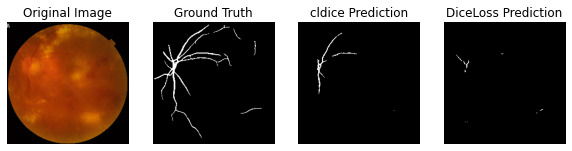

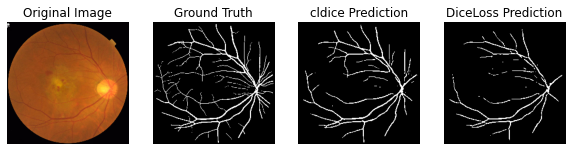

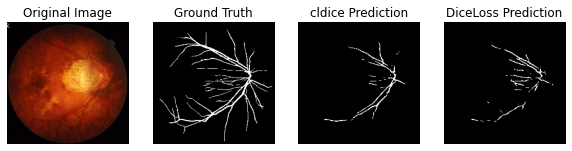

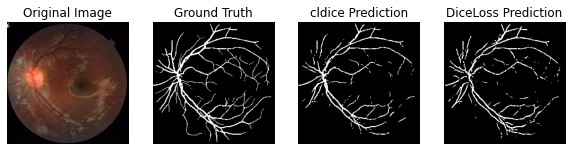

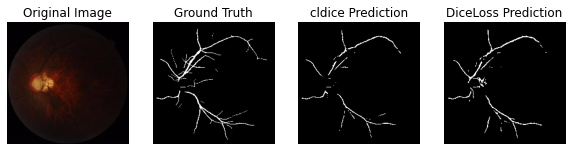

In [14]:
for i, (x, y) in enumerate(zip(data, label)):
    """ Extract the name """
    name = x.split("/")[-1].split(".")[0]

    """ read and process image """
    image, mask = read_image(x, y)
    x, y = process_image(image, mask)
    "Get Bathc predictions for the loss"
    for (model_name, model_constructor) in zip(model_names, models):
        loss_names = ["cldice", "DiceLoss"]
        predictions = get_batch_predictions(x, model_name, model_constructor, loss_names)

        visualize_sample(image, mask, predictions)
